# Exploratory Data Analysis Project -  What Sells A Car?


The purpose of this project is to determine which factors influence the price of a vehicle, based on data collected from ads that were published over the last few years. 

## Initialization

Loading libraries:

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Load data

Loading data file:

In [9]:
path = '/Data Analysis/Projects/'
data = pd.read_csv(path+'vehicles_us.csv')

### Explore initial data

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal

General information about the DataFrame:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


Sample of data:

In [11]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


From looking at the general information and the data sample, we can notice (besides the number of rows and columns) of some issues: Several (5) columns with missing values, in one of them ('is_4wd') about 50% of the values. Some columns' data type might be converted. All the missing values columns, and the inappropriate data type columns, may need further investigation.

As for missing values, the largest amount is in the 'is_4wd' column - about 50% of the values are missing. However, a brief look at the sample data indicates that probably all those missing values are '0', namely 'False' in this context. <br> Regarding the other columns I would assume that the missing values are due to incomplete ads that were published by the users. 

In regard to data types, there are numercial columns (Most of) of float data type that could be presented as int type, since there are no possible fractional parts in their values (although the influence of this issue on the analysis is not likely).
The 'date_posted' column should be changed from string (object) to datetime (timestamp) data type, so we'll be able to retrieve components and make calculations with these values later. 

### Conclusions and further steps

First overview of the initial data exposes issues such as missing values and inappropriate data types, as mentioned above. The missing value of quantitative column such as 'model_year', 'cylinders' and 'odometer' will be replaced by median values after grouping by other columns. The 'is_4wd' missinig values will be replaced with '0', supported by a probable and reasonable explanation. <br> Inappropriate data types should be changed, focusing for now on the 'date_posted' column.

The next steps are addressing missing values and converting data types where necessary, and looking for duplicates.<br> Starting with duplicates:

In [12]:
data.duplicated().sum()

0

Calculating missing values percentage for each column:

In [13]:
missing_col = ['model_year', 'cylinders', 'odometer', 'paint_color']
for col in missing_col:
    print (data[col].isna().sum() / len(data[col]))

0.07023774866569626
0.10208636584182436
0.15316836487142163
0.17985443959243086


## Treat missing values (if any)

It seems like there's no pattern for the missing values that we should look for, since there's no compatibility between amounts of missing values in the different columns. <br> As said before, the descisions are filling in missing values in numeric column with median of subgroups of other columns. <br> 
So we start with the most obvious case - filling in the NaN values of 'is_4wd' column with '0', after I make sure that all the existing values are '1'.

In [14]:
data['is_4wd'].unique()

array([ 1., nan])

Filling in missing values with '0', and checking again:

In [15]:
data['is_4wd'] = data['is_4wd'].fillna(0)
data['is_4wd'].unique()

array([1., 0.])

The other columns NaN's will be filled in using representative median values, calculated seperately for each subgroup in each parameter. For model year and cylinders missing values we'll use model column data, since there's a higher chance for an accurate estimation of details as manufacturing year and engine's cylinders, based on specific model. For milage, the best predictor is the age of the vehicle which is determined by model year. For this purpose we'll create a new column of model year groups, using a function that classify the model year data.<br> Starting with knowledge of the distribution:

In [16]:
data['model_year'].describe()

count    47906.000000
mean      2009.750470
std          6.282065
min       1908.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2019.000000
Name: model_year, dtype: float64

In [17]:
def year_group(year):
    """
    This functions classifies cars to year groups by model year
    """
    if year < 1995:
        return '1995-'
    if 2005 > year >= 1995:
        return '1995-2004'
    if 2010 > year >= 2005:
        return '2005-2009'
    if 2015 > year >= 2010:
        return '2010-2014'
    return '2015+'

data['model_year_group'] = data['model_year'].apply(year_group)

Checking if the column was added correctly:

In [18]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,model_year_group
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19,2010-2014
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50,2015+
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0.0,2019-02-07,79,2010-2014
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,0.0,2019-03-22,9,1995-2004
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0.0,2019-04-02,28,2015+


Now creating a function to fill in missing values by grouping other columns:

In [19]:
def fill_na(col1,col2,measure):
    """
    This function takes as arguments 2 columns - one with missing values and one that used
    to create groups - and one statistical measure to fill in the missing values
    """
    data[col1] = data[col1].fillna(data.groupby(col2)[col1].transform(measure))

fill_na('model_year','model','median')
fill_na('cylinders','model','median')
fill_na('odometer','model_year_group','median')
data.head()
data.info()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,model_year_group
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19,2010-2014
1,25500,2011.0,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50,2015+
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0.0,2019-02-07,79,2010-2014
3,1500,2003.0,ford f-150,fair,8.0,gas,166015.5,automatic,pickup,NaN,0.0,2019-03-22,9,1995-2004
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0.0,2019-04-02,28,2015+


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             51525 non-null  int64  
 1   model_year        51525 non-null  float64
 2   model             51525 non-null  object 
 3   condition         51525 non-null  object 
 4   cylinders         51525 non-null  float64
 5   fuel              51525 non-null  object 
 6   odometer          51525 non-null  float64
 7   transmission      51525 non-null  object 
 8   type              51525 non-null  object 
 9   paint_color       42258 non-null  object 
 10  is_4wd            51525 non-null  float64
 11  date_posted       51525 non-null  object 
 12  days_listed       51525 non-null  int64  
 13  model_year_group  51525 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 5.5+ MB


## Fix data types

Fixing the data types of 'date_posted':
<br>(Date format used: YYYY-mm-dd)

In [20]:
data['date_posted'] = pd.to_datetime(data['date_posted'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             51525 non-null  int64         
 1   model_year        51525 non-null  float64       
 2   model             51525 non-null  object        
 3   condition         51525 non-null  object        
 4   cylinders         51525 non-null  float64       
 5   fuel              51525 non-null  object        
 6   odometer          51525 non-null  float64       
 7   transmission      51525 non-null  object        
 8   type              51525 non-null  object        
 9   paint_color       42258 non-null  object        
 10  is_4wd            51525 non-null  float64       
 11  date_posted       51525 non-null  datetime64[ns]
 12  days_listed       51525 non-null  int64         
 13  model_year_group  51525 non-null  object        
dtypes: datetime64[ns](1), 

## Enrich data

Adding datetime values in seperate columns to ease future calculations:

In [21]:
data['posted_day'] = pd.DatetimeIndex(data['date_posted']).day
data['posted_month'] = pd.DatetimeIndex(data['date_posted']).month
data['posted_year'] = pd.DatetimeIndex(data['date_posted']).year

Adding vehicle age column:

In [22]:
data['vehicle_age'] = data['posted_year'] - data['model_year'] + 1

Replacing strings with numeric values in the 'condition' column to ease data manipulation:

In [23]:
condition_dict = {
    'salvage':0,
    'fair':1,
    'good':2,
    'excellent':3,
    'like new':4,
    'new':5
}
data['condition'] = data['condition'].replace(condition_dict)

Adding vehicle average mileage per year column:

In [24]:
data['mileage_avg'] = data['odometer'] / data['vehicle_age']

## Check clean data

General information of the preprocessed data:

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             51525 non-null  int64         
 1   model_year        51525 non-null  float64       
 2   model             51525 non-null  object        
 3   condition         51525 non-null  int64         
 4   cylinders         51525 non-null  float64       
 5   fuel              51525 non-null  object        
 6   odometer          51525 non-null  float64       
 7   transmission      51525 non-null  object        
 8   type              51525 non-null  object        
 9   paint_color       42258 non-null  object        
 10  is_4wd            51525 non-null  float64       
 11  date_posted       51525 non-null  datetime64[ns]
 12  days_listed       51525 non-null  int64         
 13  model_year_group  51525 non-null  object        
 14  posted_day        5152

In [26]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,model_year_group,posted_day,posted_month,posted_year,vehicle_age,mileage_avg
0,9400,2011.0,bmw x5,2,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19,2010-2014,23,6,2018,8.0,18125.000000
1,25500,2011.0,ford f-150,2,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50,2015+,19,10,2018,8.0,11088.125000
2,5500,2013.0,hyundai sonata,4,4.0,gas,110000.0,automatic,sedan,red,0.0,2019-02-07,79,2010-2014,7,2,2019,7.0,15714.285714
3,1500,2003.0,ford f-150,1,8.0,gas,166015.5,automatic,pickup,NaN,0.0,2019-03-22,9,1995-2004,22,3,2019,17.0,9765.617647
4,14900,2017.0,chrysler 200,3,4.0,gas,80903.0,automatic,sedan,black,0.0,2019-04-02,28,2015+,2,4,2019,3.0,26967.666667


## Study core parameters

The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition

To study the core parameters, histograms will be plotted to show distribution for each of these variables. <br>
For this purpose I will use a function:

In [27]:
def column_hist(DataFrame,column,bins_value=50):
    """
    This function takes a DataFrame, column and bins number (default value is set to 50) 
    as arguments and returns a histogram 
    """
    DataFrame.plot(y=column, kind='hist', bins=bins_value)
    plt.show()
    

Price histogram:

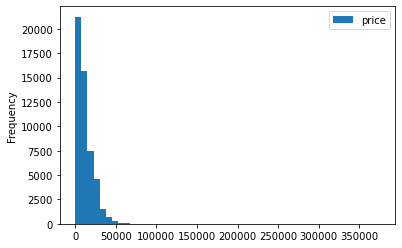

In [28]:
column_hist(data,'price')

Vehicle age histogram:

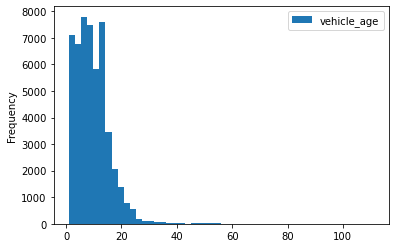

In [29]:
column_hist(data,'vehicle_age')

Mileage histogram:

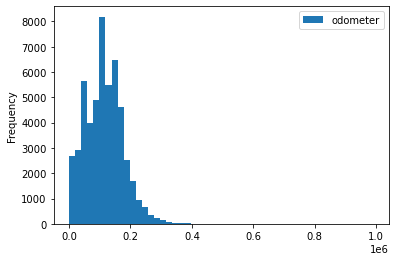

In [30]:
column_hist(data,'odometer')

Cylinders number histogram:

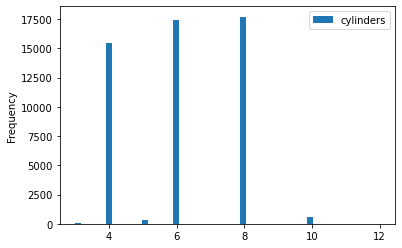

In [31]:
column_hist(data,'cylinders')

Condition histogram:

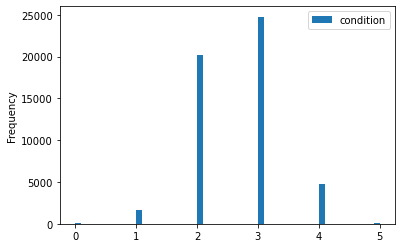

In [32]:
column_hist(data,'condition')

As we can see in the plots above, the price, age and mileage graphs contain outliers that affect dramatically their form and readability. We can notice of a right-skewed distribution, most of the values are concentrated in the low values, and an invisible long tail. 

## Study and treat outliers

From the histograms above, it's clear that the columns of price, age and mileage contain outliers.The two other columns - 'cylinders' and 'condition' - have no outliers.<br> For 'price', 'odometer' and 'vehicle_age' columns, upper limit for outliers will be determined either by 1.5 times IQR above Q3, or by the 98th percentile, using this function:

In [33]:
def outliers_limits(column):
    """
    This function takes a column from the car's data as an argument, and determines
    the upper limit of outliers by calculating 1.5 times IQR above Q3 and 98th percentile
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    print(data[column].describe())
    print('----------------------')
    print(f'Upper limit of outliers: {upper_limit}') 
    print(f'98th percentile: {np.percentile(data[column], 98)}')


In [34]:
outliers_limits('price')

count     51525.000000
mean      12132.464920
std       10040.803015
min           1.000000
25%        5000.000000
50%        9000.000000
75%       16839.000000
max      375000.000000
Name: price, dtype: float64
----------------------
Upper limit of outliers: 34597.5
98th percentile: 37995.0


The upper limit determined by the IQR method is a bit lower than the value of 98th percentile. The histogram indicates higher values of price than calculated in IQR before reaching outliers, so we'll use the 98th percentile as the upper limit.

In [35]:
outliers_limits('vehicle_age')

count    51525.000000
mean         9.513508
std          6.112895
min          1.000000
25%          5.000000
50%          8.500000
75%         13.000000
max        111.000000
Name: vehicle_age, dtype: float64
----------------------
Upper limit of outliers: 25.0
98th percentile: 24.0


In age column, 98th percentile is similar to the upper limit determined by IQR method. The greater value will be used as a limit - 25.

In [36]:
outliers_limits('odometer')

count     51525.000000
mean     114818.255197
std       61765.671701
min           0.000000
25%       68607.000000
50%      109372.000000
75%      151122.000000
max      990000.000000
Name: odometer, dtype: float64
----------------------
Upper limit of outliers: 274894.5
98th percentile: 250825.0


In this case we'll use the lower value between the 2 values above as an upper limit, namely the 98th percentile. 

Storing data wothout outliers in a new DataFrame:

In [37]:
new_data = data.query('price <= 37995 and vehicle_age <= 25 and odometer <= 250825 ')
new_data.describe()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,posted_day,posted_month,posted_year,vehicle_age,mileage_avg
count,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000,48795.000000
mean,11560.131038,2010.167579,2.642238,6.065826,112497.904171,0.489312,39.533846,15.455067,6.630946,2018.306855,9.139277,14645.898108
std,8254.002885,5.043516,0.699011,1.655722,54482.381010,0.499891,28.193604,8.739010,3.473219,0.461194,5.057137,8571.423190
min,1.000000,1994.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2018.000000,1.000000,0.000000
25%,5000.000000,2007.000000,2.000000,4.000000,70200.000000,0.000000,19.000000,8.000000,3.000000,2018.000000,5.000000,9765.617647
50%,9000.000000,2011.000000,3.000000,6.000000,109473.000000,0.000000,33.000000,15.000000,7.000000,2018.000000,8.000000,13045.000000
75%,16000.000000,2014.000000,3.000000,8.000000,149294.000000,1.000000,53.000000,23.000000,10.000000,2019.000000,12.000000,17750.000000
max,37995.000000,2019.000000,5.000000,12.000000,250825.000000,1.000000,271.000000,31.000000,12.000000,2019.000000,25.000000,195700.000000


In [38]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48795 entries, 0 to 51524
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             48795 non-null  int64         
 1   model_year        48795 non-null  float64       
 2   model             48795 non-null  object        
 3   condition         48795 non-null  int64         
 4   cylinders         48795 non-null  float64       
 5   fuel              48795 non-null  object        
 6   odometer          48795 non-null  float64       
 7   transmission      48795 non-null  object        
 8   type              48795 non-null  object        
 9   paint_color       39996 non-null  object        
 10  is_4wd            48795 non-null  float64       
 11  date_posted       48795 non-null  datetime64[ns]
 12  days_listed       48795 non-null  int64         
 13  model_year_group  48795 non-null  object        
 14  posted_day        4879

In [39]:
len(new_data) / len(data)

0.9470160116448326

After filtering we lost about 5% of the original data.  

## Study core parameters without outliers

Plots of the core parameters of the filtered data (without outliers):

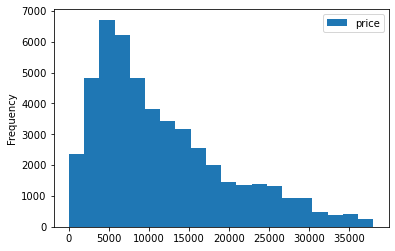

In [40]:
column_hist(new_data,'price',20)

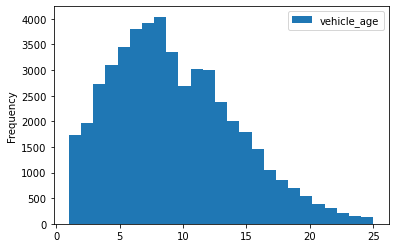

In [41]:
column_hist(new_data,'vehicle_age',25)

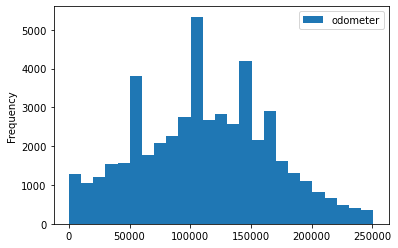

In [42]:
column_hist(new_data,'odometer',25)

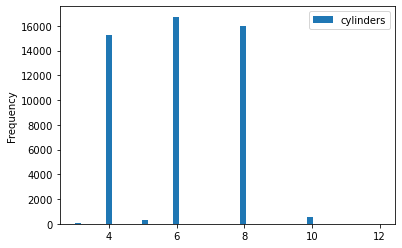

In [43]:
column_hist(new_data,'cylinders')

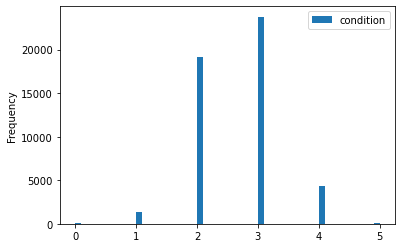

In [44]:
column_hist(new_data,'condition')

Comparison between the histograms: <br> Making the new plots using the filtered data, shows that price and age plots kept the same distribution - right skewed, while milage is closer to normal with a peak around 100K miles. Maybe if we would have determined lower limits for outliers as well, the histograms form could get slight changes. The readability of the graphs increased. In cylinders histogram, removal of outliers caused a change in the mode value - from 8 to 6. 

## Ads lifetime

To study how many days advertisements were displayed, we'll use 'days_listed' histogram:

In [45]:
new_data['days_listed'].describe()
print('days listed mean:', new_data['days_listed'].mean())
print('days listed median:', new_data['days_listed'].median())

count    48795.000000
mean        39.533846
std         28.193604
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

days listed mean: 39.53384568090993
days listed median: 33.0


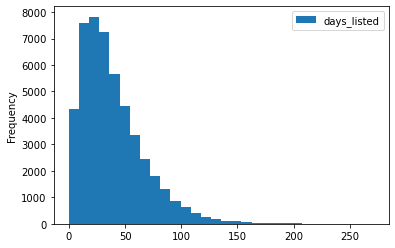

In [46]:
column_hist(new_data,'days_listed',30)

The above cells show present basic statistics and distributrion (plot) of days listed. Looking at the graph, and at the mean and median values implies that a typical lifetime of an ad is about a month (33 days to be precise). In the right-skewed distribution we would use median as a typical value rather than mean.<br> To define the time of ads listing as short or abnormally long, and try to look for a pattern for each, we'll filter the data by percentiles:

In [47]:
np.percentile(new_data['days_listed'], 98)
np.percentile(new_data['days_listed'], 2)

115.0

4.0

In [48]:
days_listed_short = new_data.query('days_listed <=4')
days_listed_short.describe()
days_listed_long = new_data.query('days_listed >= 115')
days_listed_long.describe()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,posted_day,posted_month,posted_year,vehicle_age,mileage_avg
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,11664.431245,2010.117575,2.670464,6.083808,112565.567941,0.501221,2.739626,15.694874,6.757526,2018.295362,9.177787,14570.869086
std,8137.048863,5.142059,0.702217,1.676715,54401.767634,0.500202,1.167795,8.712032,3.513555,0.456391,5.138743,8554.184198
min,1.000000,1994.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2018.000000,1.000000,0.000000
25%,5000.000000,2007.000000,2.000000,4.000000,70000.000000,0.000000,2.000000,8.000000,4.000000,2018.000000,5.000000,9812.500000
50%,9500.000000,2011.000000,3.000000,6.000000,112000.000000,1.000000,3.000000,16.000000,7.000000,2018.000000,8.000000,13045.000000
75%,15995.000000,2014.000000,3.000000,8.000000,150000.000000,1.000000,4.000000,23.000000,10.000000,2019.000000,12.000000,17479.700000
max,37995.000000,2019.000000,5.000000,10.000000,250500.000000,1.000000,4.000000,31.000000,12.000000,2019.000000,25.000000,94112.000000


,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,posted_day,posted_month,posted_year,vehicle_age,mileage_avg
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,11287.411348,2009.909828,2.625127,6.118541,115742.542047,0.488349,139.201621,15.581560,6.412361,2018.347518,9.437690,14440.953317
std,8099.066551,5.074393,0.679530,1.656364,54221.411548,0.500118,24.684806,8.783062,3.552157,0.476423,5.068188,8037.585434
min,1.000000,1994.000000,0.000000,3.000000,0.000000,0.000000,115.000000,1.000000,1.000000,2018.000000,1.000000,0.000000
25%,5200.000000,2007.000000,2.000000,4.000000,73000.000000,0.000000,122.000000,8.000000,3.000000,2018.000000,6.000000,9590.333333
50%,8995.000000,2011.000000,3.000000,6.000000,116000.000000,0.000000,132.000000,15.000000,6.000000,2018.000000,9.000000,13152.500000
75%,15125.000000,2014.000000,3.000000,8.000000,153747.500000,1.000000,149.000000,23.000000,10.000000,2019.000000,13.000000,17333.333333
max,37995.000000,2019.000000,4.000000,10.000000,248500.000000,1.000000,271.000000,31.000000,12.000000,2019.000000,25.000000,58890.000000


Surprisingly, ads that were removed after only 4 days and ads that have been listed almost 4 months, share similar statistics regarding the other factors. 

## Average price per each type of vehicle

To analyze the number of ads and average price for each type of vehicle, we'll plot a histogram that shows the number of ads for each type:

<AxesSubplot:>

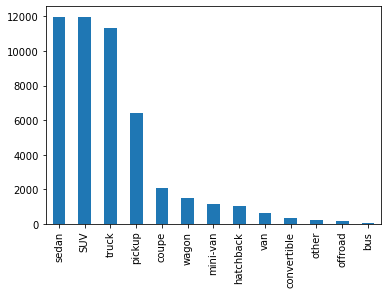

In [49]:
new_data['type'].value_counts().plot(kind='bar')
plt.show()

The next pivot table shows the average price and nubmer of ads ('count' column) for each vehicle type:

In [50]:
new_data.pivot_table(
    index='type', values='price', aggfunc=['mean', 'count'])

,mean,count
,price,price
type,,
SUV,10707.108874,11968
bus,17445.913043,23
convertible,12819.307910,354
coupe,13655.056235,2045
hatchback,6842.486083,1006
mini-van,8072.185802,1141
offroad,14633.155914,186
other,10711.179916,239


As we can see in the plot and pivot table above, the two vehicle types with the greatest number of ads are 'sedan' and 'SUV'.

## Price factors

Lets start with splitting the data to the 2 most popular types:

In [51]:
suv_data = new_data.query('type == "SUV"')
sedan_data = new_data.query('type == "sedan"')

Plotting box-and-whisker charts for categorical variables - transmission and color.
<br>
Checking if each variable's category has at least 50 ads, and then plotting the graphs by this function:

In [52]:
def box_cat(category,DataFrame):
    print(DataFrame[category].value_counts())
    sns.boxplot(x=category, y='price', data=DataFrame, showfliers=False)
    plt.show()

automatic    11349
manual         461
other          158
Name: transmission, dtype: int64


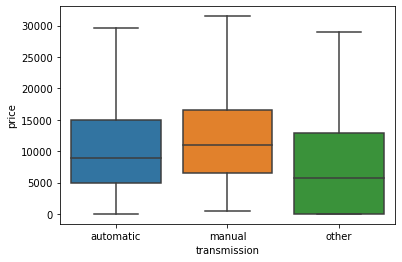

In [53]:
box_cat('transmission', suv_data)

black     2109
white     1890
silver    1529
grey      1156
blue      1013
red        879
green      413
brown      353
custom     299
orange      82
yellow      47
purple      37
Name: paint_color, dtype: int64


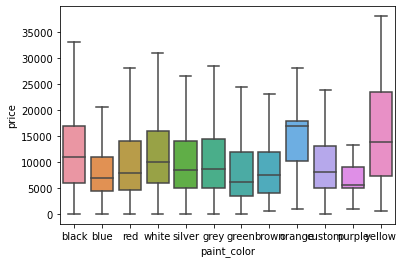

In [54]:
box_cat('paint_color', suv_data)
sns.set(rc={'figure.figsize':(12,5)})

As noted in the above distribution, there are 2 color categories - yellow and purple - with less than 50 ads, thus are not valid for analysis. Black is the most popular color for SUV cars.

Now the categorical variables distributions and boxplots for truck type:

automatic    11276
manual         574
other          132
Name: transmission, dtype: int64


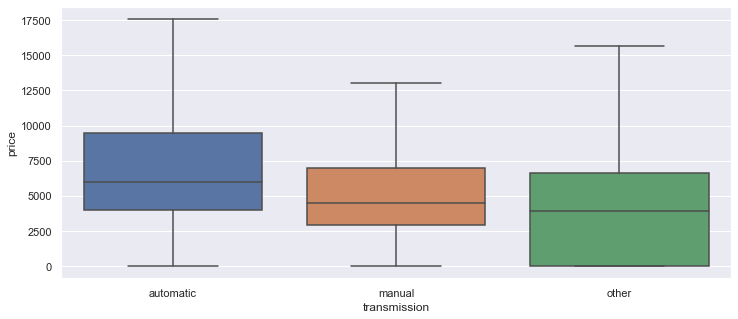

In [55]:
box_cat('transmission', sedan_data)

Most of the sedan cars have an automatic transmission.

silver    2027
black     1756
grey      1608
white     1486
blue      1217
red        934
custom     296
brown      252
green      197
purple      23
yellow      21
orange       9
Name: paint_color, dtype: int64


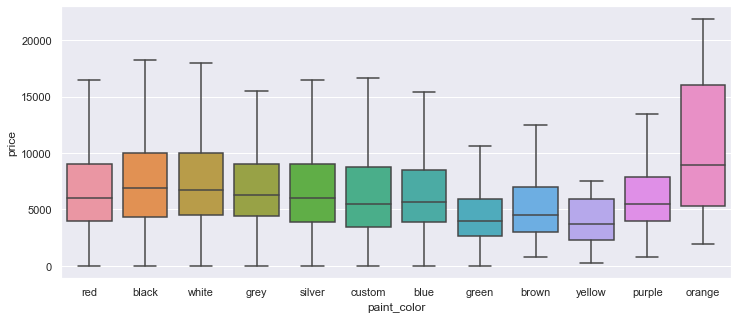

In [56]:
box_cat('paint_color', sedan_data)
sns.set(rc={'figure.figsize':(12,5)})

Like in SUV colors, here again we can notice of 3 colors below 50 ads threshold - purple, yellow and orange. Silver is the most popular color for sedan cars.

As for the numerical categories, I will use correlation plot for visualization of price-category relationship, and correlation matrix to find correlation values.
First a pivot table will be created for the relevant categories, then plot.

,price,vehicle_age,odometer,condition
price,1.000000,-0.576294,-0.523394,0.262771
vehicle_age,-0.576294,1.000000,0.618898,-0.309732
odometer,-0.523394,0.618898,1.000000,-0.312717
condition,0.262771,-0.309732,-0.312717,1.000000


array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='price'>,
        <AxesSubplot:xlabel='odometer', ylabel='price'>,
        <AxesSubplot:xlabel='condition', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='odometer', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='condition', ylabel='vehicle_age'>],
       [<AxesSubplot:xlabel='price', ylabel='odometer'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='odometer'>,
        <AxesSubplot:xlabel='odometer', ylabel='odometer'>,
        <AxesSubplot:xlabel='condition', ylabel='odometer'>],
       [<AxesSubplot:xlabel='price', ylabel='condition'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='condition'>,
        <AxesSubplot:xlabel='odometer', ylabel='condition'>,
        <AxesSubplot:xlabel='condition', ylabel='condition'>]],
      dtype=object)

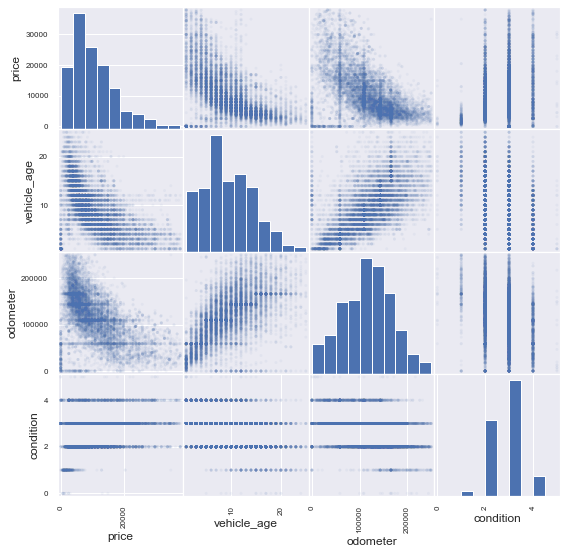

In [57]:
num_data_suv = suv_data[['price', 'vehicle_age', 'odometer', 'condition']]
num_data_suv.corr()
pd.plotting.scatter_matrix(num_data_suv, figsize=(9,9), alpha=0.05)
plt.show()

Analyzing the SUV data reveals that the strongest correlation exists between price and vehicle age or mileage, with pearson coefficient of -0.58 and -0.52 respectively. That is, a negative coefficient - an increase in age and mileage is correlated with a decrese in price.

Now the same analysis for sedan data:

,price,vehicle_age,odometer,condition
price,1.000000,-0.613376,-0.550621,0.290547
vehicle_age,-0.613376,1.000000,0.606832,-0.291364
odometer,-0.550621,0.606832,1.000000,-0.312435
condition,0.290547,-0.291364,-0.312435,1.000000


array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='price'>,
        <AxesSubplot:xlabel='odometer', ylabel='price'>,
        <AxesSubplot:xlabel='condition', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='odometer', ylabel='vehicle_age'>,
        <AxesSubplot:xlabel='condition', ylabel='vehicle_age'>],
       [<AxesSubplot:xlabel='price', ylabel='odometer'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='odometer'>,
        <AxesSubplot:xlabel='odometer', ylabel='odometer'>,
        <AxesSubplot:xlabel='condition', ylabel='odometer'>],
       [<AxesSubplot:xlabel='price', ylabel='condition'>,
        <AxesSubplot:xlabel='vehicle_age', ylabel='condition'>,
        <AxesSubplot:xlabel='odometer', ylabel='condition'>,
        <AxesSubplot:xlabel='condition', ylabel='condition'>]],
      dtype=object)

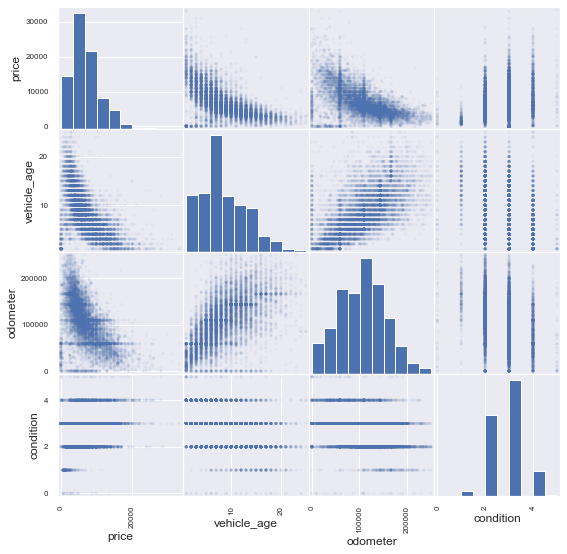

In [58]:
num_data_sedan = sedan_data[['price', 'vehicle_age', 'odometer', 'condition']]
num_data_sedan.corr()
pd.plotting.scatter_matrix(num_data_sedan, figsize=(9,9), alpha=0.05)
plt.show()

Same conclusion for the sedan type - the strongest correlation of -0.61 is between price and age, while price-mileage shows value of -0.55. 

## General conclusion

The first step was data preprocessing, as there were several issues to address. Those included missing values, inappropriate data types, and adding columns to ease calculations. With regard to missing values, grouping by other columns was used to provide with median values, while obvious case was treated directly based on reliable reasoning. <br> No duplicates were found.
<br>
Outliers upper limit was determined either by the IQR method or by 98th percentile. Various reasons might account for these outliers. Numeric characteristic of a car - such as mileage, age and price - can present a wide range of values. A large dataset of vehicles will probably include very expensive (or cheap) cars, and is likely to stretch over wide range of model years, alongside various owners' profiles that influence factors as milage. Of course we can't ignore and disprove human typing errors as well.
<br>
After storing the relevant data in a new dataset, the histograms, correlation matrices and correlation plots led to the following conclusion:
<br>
The factors that influence the price of a vehicle more than others are the vehicle's age and mileage, mostly the age. These two factors had the highest correlation (negative) with the price, as shown in the correlation matrix and clearly visualized in the scatter matrix. 